
Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.


A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available. Training on GPU ...')
else:
    print('CUDA not available. Training on CPU ...')

CUDA not available. Training on CPU ...


### Load the data

We are using MINIST Dataset

In [68]:
# Define a transform the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [73]:
10000/32

312.5

In [75]:
len(testloader)

313

Define the network
------------------

Let’s define this network:



In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = nn.LogSoftmax(dim=1)(x)
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [76]:
# use GPU if available
if train_on_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [77]:
# Loss Function
criterion = nn.NLLLoss()

net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [79]:
# optimizer 
from torch import optim
optimizer =  optim.SGD(net.parameters(), lr=0.003)

### Training the Network

In [116]:
epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    net.train()
    for images, labels in trainloader:
        # move tensors to GPU is CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Flatten Image
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        
        log_ps = net(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        net.eval()
        with torch.no_grad():
            for images, labels in testloader:
                # move tensors to GPU is CUDA is available
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Flatten Image
                images = images.view(images.shape[0], -1)
                log_ps = net(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        # print training/test statistics
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 0.209..  Test Loss: 0.206..  Test Accuracy: 0.941
Epoch: 2/15..  Training Loss: 0.202..  Test Loss: 0.198..  Test Accuracy: 0.942


KeyboardInterrupt: 

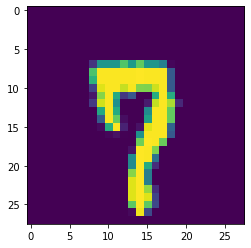

In [114]:
idx = 0
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[idx].view(1, 784)

# Calculate the class probabilities (softmax) for img
ps = torch.exp(net(img))
plt.imshow(images[idx].view(28,28))

In [115]:
torch.argmax(ps)

tensor(7)